#  Pawnee Fire Analysis

> * 🔬 Data Science
* 🖥️ Requires RasterAnalytics Portal Configuration
* 🖥️ Requires GeoEnrichment Portal Configuration
* 🖥️ Requires GeoAnalytics Portal Configuration

The Pawnee Fire was a large wildfire that burned in Lake County, California. The fire started on June 23, 2018 and burned a total of 15,185 acres (61 km2) before it was fully contained on July 8, 2018.

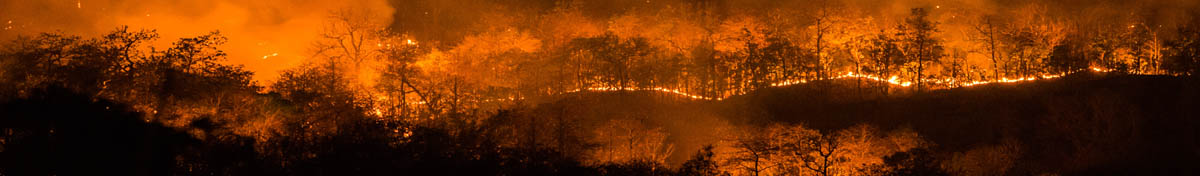

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pawnee-Fire-analysis" data-toc-modified-id="Pawnee-Fire-analysis-1">Pawnee Fire Analysis</a></span><ul class="toc-item"><li><span><a href="#Remote-Sensing-using-Sentinel-2-data" data-toc-modified-id="Remote-Sensing-using-Sentinel-2-data-1.1">Remote Sensing using Sentinel-2 data</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.2">Data Preparation</a></span></li><li><span><a href="#Visual-Assessment" data-toc-modified-id="Visual-Assessment-1.3">Visual Assessment</a></span></li><li><span><a href="#Quantitative-Assessment" data-toc-modified-id="Quantitative-Assessment-1.4">Quantitative Assessment</a></span></li><li><span><a href="#Impact-Assessment" data-toc-modified-id="Impact-Assessment-1.5">Impact Assessment</a></span></ul></li>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2">Conclusion</a></span></li></ul></div>

## Remote Sensing using Sentinel-2 data

In [1]:
from datetime import datetime
import warnings

from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import arcgis
from arcgis import GIS
from arcgis.raster.functions import *
from arcgis.geoanalytics.use_proximity import create_buffers
from arcgis.geoenrichment import enrich
from arcgis.features import SpatialDataFrame
from arcgis.raster.analytics import create_image_collection
from arcgis.raster.analytics import list_datastore_content

gis= GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

### Data Preparation

In this analysis, we will be using Sentinel-2 data.

Sentinel-2 is an Earth observation mission developed by ESA as part of the Copernicus Programme to perform terrestrial observations in support of services such as forest monitoring, land cover change detection, and natural disaster management.

In this analysis data downloaded from https://earthexplorer.usgs.gov/ is used for creating hosted image service. 
We add the data to the datastore and we then run the create_image_collection function which creates a collection with the input_rasters specified and publishes the collection as an image service. 


We use list_datasore_content() in order to see the contents in the rasterstore.

In [2]:
list_datastore_content("/rasterStores/LocalRasterStore")

['/rasterStores/LocalRasterStore/Hosted_GeneratedRasterProduct_AANS52.crf/',
 '/rasterStores/LocalRasterStore/L1C_T10SEJ_A015697_20180624T190108.zip',
 '/rasterStores/LocalRasterStore/me.txt',
 '/rasterStores/LocalRasterStore/m_7013bfcd7273e0a4a779fce061167d5c/',
 '/rasterStores/LocalRasterStore/m_b5f745ad6ef601d5e6adf104c8b4ef70/',
 '/rasterStores/LocalRasterStore/m_d0221b176ab5ed2398828b8079d62ef8/',
 '/rasterStores/LocalRasterStore/pawnee_fire_multispectral/',
 '/rasterStores/LocalRasterStore/pool_chips_1/',
 '/rasterStores/LocalRasterStore/pool_chips_2/',
 '/rasterStores/LocalRasterStore/S2A_MSIL1C_20180624T184921_N0206_R113_T10SEJ_20180624T234856.SAFE/',
 '/rasterStores/LocalRasterStore/S2B_MSIL1C_20180622T185919_N0206_R013_T10SEJ_20180622T205930.SAFE/',
 '/rasterStores/LocalRasterStore/sentinel_data/']

In [3]:
sentinel_collection = create_image_collection(image_collection="pawnee_fire_multispectral",
                      input_rasters=["/rasterStores/LocalRasterStore/S2A_MSIL1C_20180624T184921_N0206_R113_T10SEJ_20180624T234856.SAFE",
                                     "/rasterStores/LocalRasterStore/S2B_MSIL1C_20180622T185919_N0206_R013_T10SEJ_20180622T205930.SAFE"],
                      raster_type_name="Sentinel-2", 
                      raster_type_params={"productType":"All","processingTemplate":"Multispectral"},
                      context={"image_collection_properties":{"imageCollectionType":"Satellite"},"byref":True}, gis = gis)

In [9]:
sentinel = sentinel_collection.layers[0]

### Select before and after rasters

In [10]:
aoi = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmax': -13643017.100720055,
 'xmin': -13652113.10708598,
 'ymax': 4739654.477447927,
 'ymin': 4731284.622850712}
arcgis.env.analysis_extent = aoi
sentinel.extent = aoi

In [11]:
selected = sentinel.filter_by(where="acquisitiondate BETWEEN timestamp '2018-06-15 00:00:00' AND timestamp '2018-06-24 19:59:59'",
                              geometry=arcgis.geometry.filters.intersects(aoi))

df = selected.query(out_fields="*", order_by_fields="OBJECTID ASC").df
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df.tail(40)

,AcquisitionDate,Category,CenterX,CenterY,CloudCover,CreationTime,Creator,GroupName,HighPS,LowPS,...,SOrder,SensingOrbit,SensorName,Shape_Area,Shape_Length,StereoID,Tag,Thumbnail,ZOrder,SHAPE
0,2018-06-24 18:49:21.024,1,-1.362127e+07,4.758219e+06,0,1548778472000,rjackson,MTD_MSIL1C,60,60,...,None,113,Sentinel-2A,2.008228e+10,562920.108277,None,MS,None,None,"{'rings': [[[-13549665.930399999, 4828694.125]..."
1,2018-06-22 18:59:19.024,1,-1.364188e+07,4.762904e+06,0,1548778472000,rjackson,MTD_MSIL1C,60,60,...,None,13,Sentinel-2B,1.417943e+10,488606.729731,None,MS,None,None,"{'rings': [[[-13611168.835900001, 4689604.0966..."


In [12]:
prefire = sentinel.filter_by('OBJECTID=2') 
midfire = sentinel.filter_by('OBJECTID=1')

## Visual Assessment

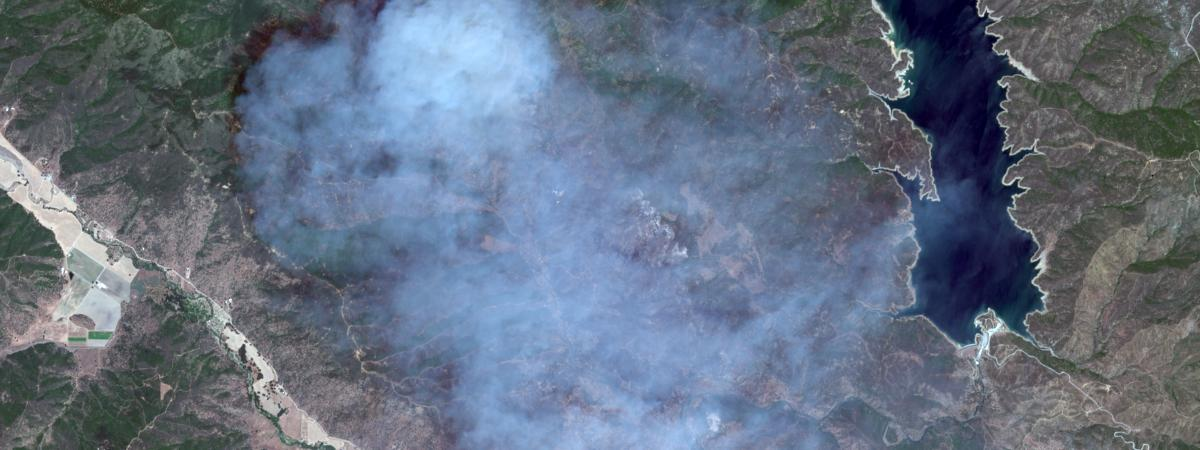

In [13]:
truecolor = extract_band(midfire, [4,3,2])
truecolor

### Visualize Burn Scars

We extract the [13, 12, 4] bands to improve visibility of fire and burn scars. This band combination pushes further into the SWIR range of the electromagnetic spectrum, where there is less susceptibility to smoke and haze generated by a burning fire.

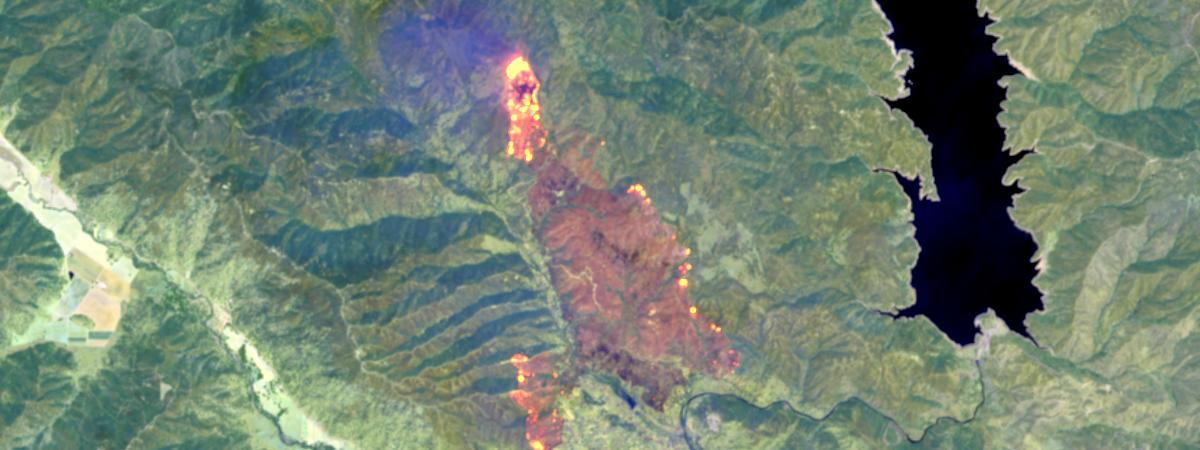

In [9]:
extract_band(midfire, [13,12,4])


For comparison, the same area before the fire started shows no burn scar.

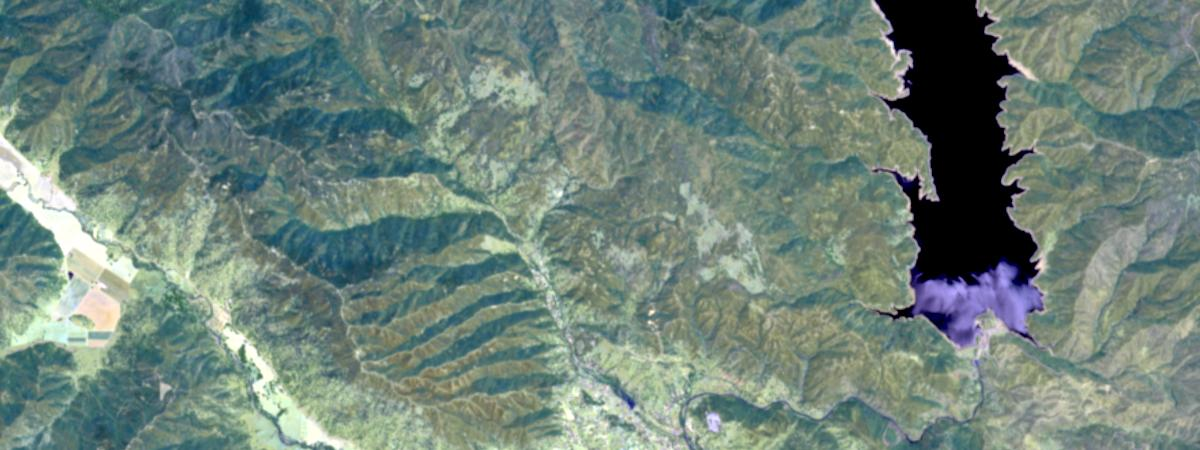

In [10]:
extract_band(prefire, [13,12,4])


## Quantitative Assessment

The **Normalized Burn Ratio (NBR)** can be used to delineate the burnt areas and identify the severity of the fire. 

The formula for the NBR is very similar to that of NDVI except that it uses near-infrared band 9 and the short-wave infrared band 13:
\begin{align}
{\mathbf{NBR}} = \frac{\mathbf{B9} - \mathbf{B13}}{\mathbf{B9} + \mathbf{B13} + \mathbf{WS}} \\   
\end{align}

The NBR equation was designed to be calcualted from reflectance, but it can be calculated from radiance and digital_number_(dn) with changes to the burn severity table below. The WS parameter is used for water suppression, and is typically 2000. 

For a given area, NBR is calculated from an image just prior to the burn and a second NBR is calculated for an image immediately following the burn. Burn extent and severity is judged by taking the difference between these two index layers:

\begin{align}
{\Delta \mathbf{NBR}} = \mathbf{NBR_{prefire}} - \mathbf{NBR_{postfire}} \\   
\end{align}

The meaning of the ∆NBR values can vary by scene, and interpretation in specific instances should always be based on some field assessment. However, the following table from the USGS FireMon program can be useful as a first approximation for interpreting the NBR difference:


| \begin{align}{\Delta \mathbf{NBR}}  \end{align}      | Burn Severity |
| ------------- |:-------------:|
| 0.1 to 0.27   | Low severity burn |
| 0.27 to 0.44  | Medium severity burn |
| 0.44 to 0.66 | Moderate severity burn |
| > 0.66 | High severity burn |

[Source: http://wiki.landscapetoolbox.org/doku.php/remote_sensing_methods:normalized_burn_ratio]

### Use Band Arithmetic and Map Algebra 

In order to perform raster analysis on raw pixel value, we filter out the scenes from the sentinel image service again and create new layers

In [11]:
nbr_prefire  = band_arithmetic(prefire, "(b9 - b13) / (b9 + b13 + 2000)")
nbr_postfire = band_arithmetic(midfire, "(b9 - b13) / (b9 + b13 + 2000)")

nbr_diff = nbr_prefire - nbr_postfire

In [12]:
burnt_areas = colormap(remap(nbr_diff, 
                             input_ranges=[0.1,  0.27,  # low severity 
                                           0.27, 0.44,  # medium severity
                                           0.44, 0.66,  # moderate severity
                                           0.66, 1.00], # high severity burn
                             output_values=[1, 2, 3, 4],                    
                             no_data_ranges=[-1, 0.1], astype='u8'), 
                       colormap=[[4, 0xFF, 0xC3, 0], [3, 0xFA, 0x8E, 0], [2, 0xF2, 0x55, 0], [1, 0xE6, 0,    0]])

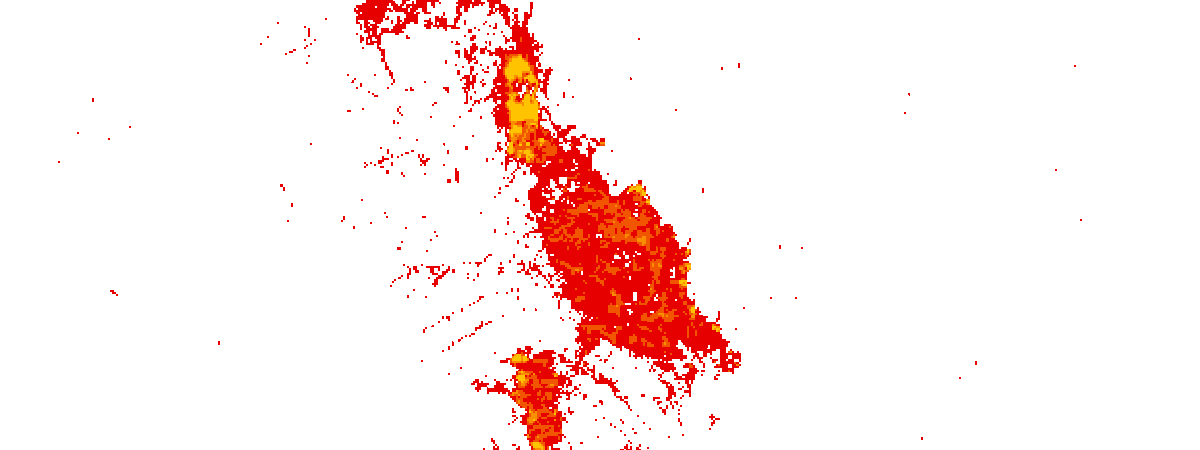

In [13]:
# Visualize burnt areas
burnt_areas

With this, we have computed the NBR on scenes from before and after the burn, and computed the NBR difference to identify places that have been affected by the fire. We've also normalized the values to match a burn severity index, and applied a color map that brings out the extent of fire damage.


### Area calculation

In [14]:
pixx = (aoi['xmax'] - aoi['xmin']) / 1200.0
pixy = (aoi['ymax'] - aoi['ymin']) / 450.0

res = burnt_areas.compute_histograms(aoi, pixel_size={'x':pixx, 'y':pixy})

numpix = 0
histogram = res['histograms'][0]['counts'][1:]
for i in histogram:
    numpix += i

### Report burnt area

In [15]:
sqmarea = numpix * pixx * pixy # in sq. m
acres = 0.00024711 * sqmarea   # in acres

HTML('<h3>Fire has consumed <font color="red">{:,} acres</font>  till {}</h3>.' \
     .format(int(acres), df.iloc[-1]['AcquisitionDate'].date()))

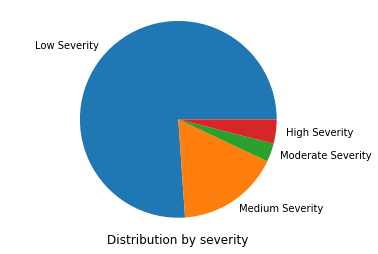

In [16]:
%matplotlib inline

plt.title('Distribution by severity', y=-0.1)
plt.pie(histogram, labels=['Low Severity', 'Medium Severity', 'Moderate Severity', 'High Severity']);
plt.axis('equal');

### Visualize burnt areas


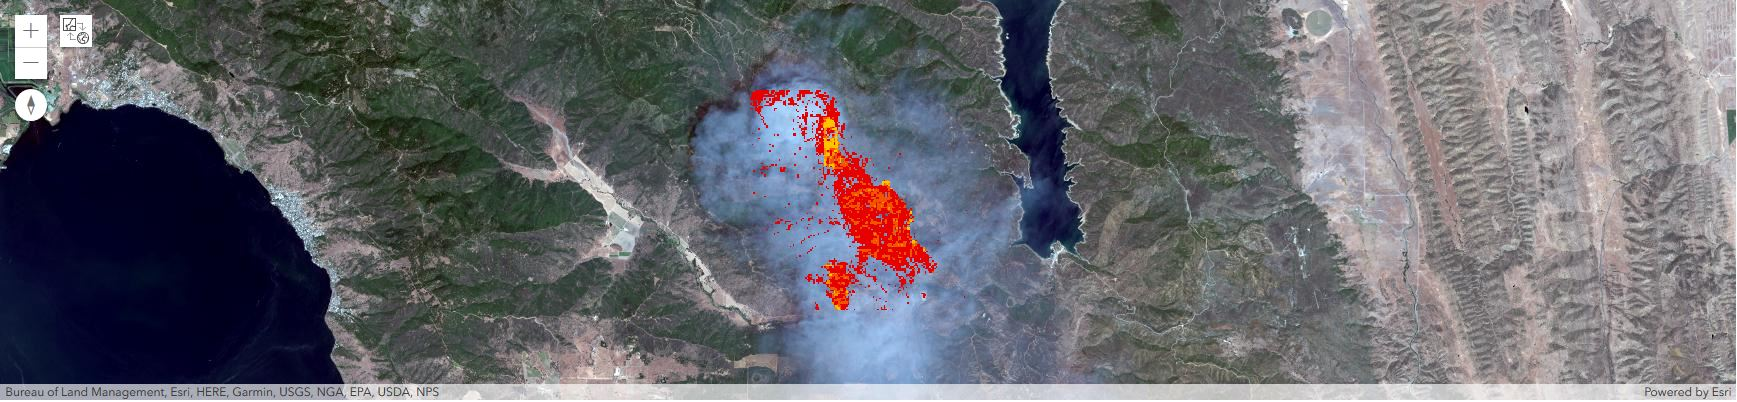

In [35]:
firemap = gis.map()
firemap.extent = aoi
firemap.add_layer([truecolor, burnt_areas])

firemap

### Persist the burnt areas layer in the GIS

If required, using the save(), we can persist the output in the gis as a new layer. This uses distributed raster analysis to perform the analysis at the source resolution.

In [18]:
burnt_areas = burnt_areas.save()

## Raster to Feature layer conversion

Use Raster Analytics and Geoanalytics to convert the burnt area raster to a feature layer. The `to_features()` method converts the raster to a feature layer and `create_buffers()` fills holes in the features and dissolves them to output one feature that covers the extent of the Pawnee Fire.

In [19]:
burnt_areas = burnt_areas.layers[0]
fire_item = burnt_areas.to_features(output_name='Pawnee_Fire_Feature_Layer', gis=gis)
fire_layer = fire_item.layers[0]


In [3]:
fire = create_buffers(fire_layer, 100, 'Meters', dissolve_option='All', multipart=True, output_name='PawneeFireArea_Buffer')
fire = fire.layers[0]

## Visualize Feature Layer


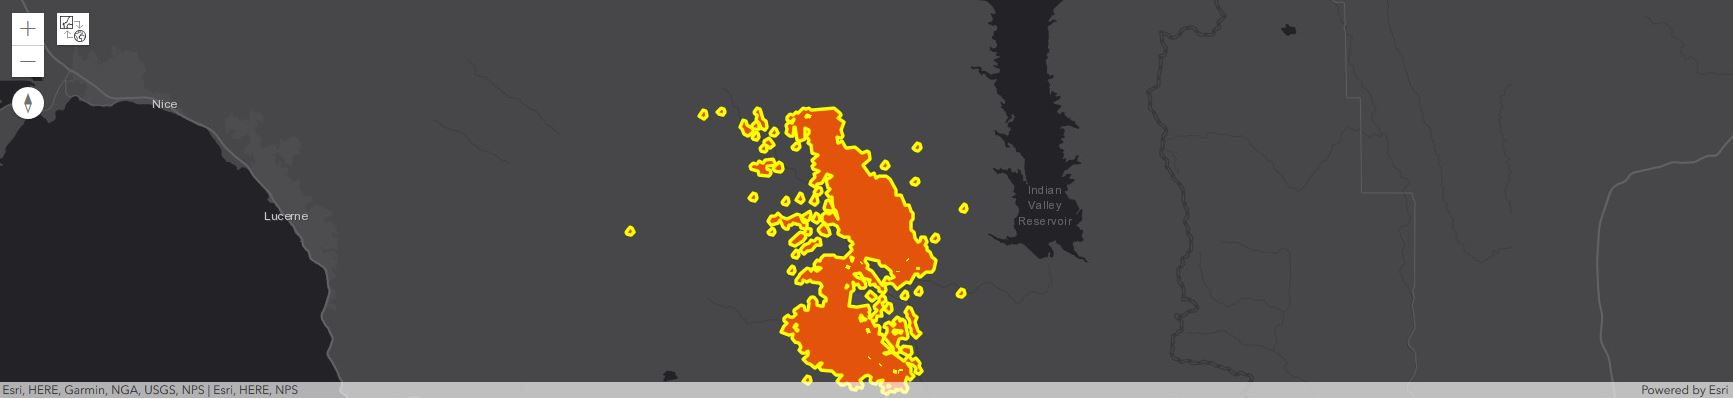

In [40]:
vectormap = gis.map()
vectormap.basemap = 'dark-gray'
vectormap.extent  = aoi

vectormap.add_layer(fire)
vectormap

## Impact Assessment

### Assess Human Impact

In [24]:
from arcgis import geometry 
 
sdf = SpatialDataFrame.from_layer(fire)

fire_geometry = sdf.iloc[0].SHAPE
sa_filter = geometry.filters.intersects(geometry=fire_geometry, sr=4326)

def age_pyramid(df):
    %matplotlib inline
    warnings.simplefilter(action='ignore', category=FutureWarning)
    pd.options.mode.chained_assignment = None 
    plt.style.use('ggplot')

    df = df[[x for x in impacted_people.columns if 'MALE' in x or 'FEM' in x]]
    sf = pd.DataFrame(df.sum())
    age = sf.index.str.extract('(\d+)').astype('int64')
    f = sf[sf.index.str.startswith('FEM')]
    m = sf[sf.index.str.startswith('MALE')]
    sf = sf.reset_index(drop = True)
    f = f.reset_index(drop = True)
    m = m.reset_index(drop = True)
    sf['age'] = age
    f["age"] = age
    m["age"] = age
    f = f.sort_values(by='age', ascending=False).set_index('age')
    m = m.sort_values(by='age', ascending=False).set_index('age')
    

    popdf = pd.concat([f, m], axis=1)
    popdf.columns = ['F', 'M']
    popdf['agelabel'] = popdf.index.map(str) + ' - ' + (popdf.index+4).map(str)
    popdf.M = -popdf.M
    
    sns.barplot(x="F", y="agelabel", color="#CC6699", label="Female", data=popdf, edgecolor='none')
    sns.barplot(x="M",  y="agelabel", color="#008AB8", label="Male",   data=popdf,  edgecolor='none')
    plt.ylabel('Age group')
    plt.xlabel('Number of people');
    return plt;

### Age Pyramid of Affected Population

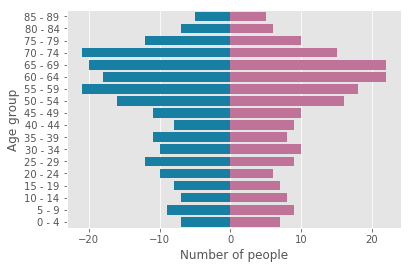

In [25]:
impacted_people = enrich(sdf, 'Age')
age_pyramid(impacted_people);

# Conclusion

In this notebook example, we used Sentinel-2 data in order to perform remote sensing. For this we filtered out pre and post fire scenes. Using extract_band() we carried out visual assessment of the burnt area. We then computed the NBR on these scenes and computed the NBR difference to identify places that have been affected by the fire, using raster functions. We also normalized the values to match the burn severity index, applied a color map raster function that brings out the extent of fire damage and calculated the burnt area. Finally, we carried out a human impact assessment by plotting the age pyramid of affected population 




![](img/wildfire_banner.jpg)